# LightGBM


## 1.导入相关库

In [30]:
import numpy as np
import pandas as pd

#preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from tqdm import tqdm

#visualizations
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#algorithms
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#score metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score



## 2.读取数据

In [31]:
# path = '/home/kesci/data/competition_A/'
path = './data/competition_A/'
train_df = pd.read_csv(path+'train_set.csv')
test_df  = pd.read_csv(path+'test_set.csv')
submission  =  pd.read_csv(path+'submission_example.csv')
print('Train Shape:{}\nTest Shape:{}'.format(train_df.shape,test_df.shape))
train_df.head(5)


Train Shape:(6000, 31)
Test Shape:(2785, 30)


,年龄,性别,区域,体重,身高,体重指数,肥胖腰围,腰围,最高血压,最低血压,好胆固醇,坏胆固醇,总胆固醇,血脂异常,PVD,体育活动,教育,未婚,收入,护理来源,视力不佳,饮酒,高血压,家庭高血压,糖尿病,家族糖尿病,肝炎,家族肝炎,慢性疲劳,ALF,ID
0,58,F,east,75.6,174.9,24.71,0.0,94.8,100.0,52.0,35.0,95.0,130.0,0,0,1.0,0.0,0.0,0.0,Private Hospital,0.0,0,1.0,1,0,1,1.0,0.0,1.0,0.0,4379
1,85,F,east,66.3,166.1,24.03,0.0,89.6,134.0,84.0,59.0,153.0,212.0,0,0,2.0,0.0,0.0,0.0,Private Hospital,0.0,1,0.0,0,0,0,0.0,0.0,0.0,NaN,7623
2,32,F,east,109.9,173.2,36.64,1.0,111.7,124.0,84.0,39.0,133.0,172.0,0,0,2.0,1.0,0.0,1.0,Private Hospital,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,1764
3,22,M,east,58.7,171.3,20.00,0.0,78.0,104.0,56.0,48.0,98.0,146.0,0,0,2.0,1.0,1.0,0.0,Never Counsulted,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,5450
4,44,F,west,79.7,172.1,26.91,0.0,93.8,114.0,60.0,34.0,195.0,229.0,0,0,2.0,0.0,0.0,0.0,Private Hospital,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,5196


## 3.数据EDA

In [32]:
train_df.describe()

# total_missingvalues = train_df.isnull().sum()
# total_missingvalues

,年龄,体重,身高,体重指数,肥胖腰围,腰围,最高血压,最低血压,好胆固醇,坏胆固醇,总胆固醇,血脂异常,PVD,体育活动,教育,未婚,收入,视力不佳,饮酒,高血压,家庭高血压,糖尿病,家族糖尿病,肝炎,家族肝炎,慢性疲劳,ALF,ID
count,6000.000000,5860.000000,5864.000000,5791.000000,5791.000000,5776.000000,5781.000000,5727.000000,5994.000000,5993.000000,5993.000000,6000.000000,6000.00000,5992.000000,5986.000000,5692.000000,5237.000000,5598.000000,6000.000000,5951.000000,6000.000000,6000.000000,6000.000000,5984.000000,5995.000000,5974.000000,4119.000000,6000.000000
mean,49.331000,79.140884,167.037142,28.306374,0.317044,96.837846,125.582944,71.469356,51.627794,152.999166,204.628066,0.105833,0.04150,2.017190,0.434347,0.366831,0.418178,0.065916,0.301000,0.401613,0.239500,0.110333,0.314500,0.067179,0.020684,0.031637,0.074775,4362.312833
std,18.784868,19.293747,10.124373,6.136871,0.465365,14.928330,21.004949,12.663285,15.518744,42.745425,42.707270,0.307650,0.19946,0.812113,0.495712,0.481982,0.493307,0.248158,0.458731,0.490266,0.426814,0.313331,0.464355,0.250353,0.142336,0.175047,0.263061,2538.515901
min,20.000000,33.700000,130.400000,14.420000,0.000000,58.600000,72.000000,10.000000,12.000000,27.000000,72.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,65.600000,159.700000,24.080000,0.000000,86.300000,111.000000,64.000000,41.000000,124.000000,176.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2142.750000
50%,47.000000,76.700000,166.600000,27.390000,0.000000,96.300000,122.000000,72.000000,49.000000,150.000000,201.000000,0.000000,0.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4363.500000
75%,65.000000,89.525000,174.200000,31.390000,1.000000,106.100000,136.000000,79.000000,60.000000,178.000000,230.000000,0.000000,0.00000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6558.250000
max,85.000000,191.100000,200.100000,66.440000,1.000000,166.000000,233.000000,132.000000,160.000000,684.000000,727.000000,1.000000,1.00000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8784.000000


### 3.1 根据训练集的列可以得到大致如下三种特征：数字列、二值列（0或1）、字符列

In [33]:
# 数字列
num_columns = ['年龄','体重','身高','体重指数', '腰围', '最高血压', '最低血压',
                '好胆固醇', '坏胆固醇', '总胆固醇','收入']
# 二值列
zero_to_one_columns = ['肥胖腰围','血脂异常','PVD']

# 字符列
str_columns = ['性别','区域','体育活动','教育','未婚','护理来源','视力不佳','饮酒','高血压',
                '家庭高血压', '糖尿病', '家族糖尿病','家族肝炎', '慢性疲劳','ALF']


#### 3.1.1 肝炎与年龄

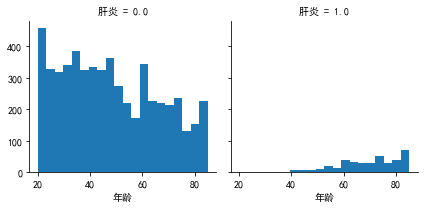

In [34]:
g = sns.FacetGrid(train_df, col='肝炎')
g.map(plt.hist, '年龄', bins=20)

### 3.2 特征工程

In [35]:
train_df.dtypes

年龄         int64
性别        object
区域        object
体重       float64
身高       float64
体重指数     float64
肥胖腰围     float64
腰围       float64
最高血压     float64
最低血压     float64
好胆固醇     float64
坏胆固醇     float64
总胆固醇     float64
血脂异常       int64
PVD        int64
体育活动     float64
教育       float64
未婚       float64
收入       float64
护理来源      object
视力不佳     float64
饮酒         int64
高血压      float64
家庭高血压      int64
糖尿病        int64
家族糖尿病      int64
肝炎       float64
家族肝炎     float64
慢性疲劳     float64
ALF      float64
ID         int64
dtype: object

In [36]:
# 处理缺失值
train_df.fillna(method='ffill', inplace=True)
test_df.fillna(0, inplace=True)

# One-hot编码
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)


# 字符编码
# for i in tqdm(str_columns):
#     lbl = LabelEncoder()
#     train_df[i] = lbl.fit_transform(train_df[i].astype(str))
#     test_df[i] = lbl.fit_transform(test_df[i].astype(str))
#

# 字符列

features = num_columns

#数值归一化
train_df[features] = MinMaxScaler().fit_transform(train_df[features])
test_df[features] = MinMaxScaler().fit_transform(test_df[features])



## 4.模型

### 4.1 准备数据集

In [37]:
all_columns = [i for i in train_df.columns if i not in ['肝炎','ID']]

train_x, train_y = train_df[all_columns].values, train_df['肝炎'].values
test_x  = test_df[all_columns].values
submission['hepatitis'] = 0

### 4.2 训练模型

In [38]:
kfold = StratifiedKFold(n_splits=5, shuffle=False)

parameters = {
              'max_depth': [15, 20, 25, 30, 35],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              'feature_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
              'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
              'bagging_freq': [2, 4, 5, 6, 8],
              'lambda_l1': [0, 0.1, 0.4, 0.5, 0.6],
              'lambda_l2': [0, 10, 15, 35, 40],
              'cat_smooth': [1, 10, 15, 20, 35]
}

model = LGBMClassifier(
    boosting_type="gbdt", num_leaves=120, reg_alpha=0, reg_lambda=0.,
    max_depth=-1, n_estimators=200, objective='binary',
    subsample=0.9, colsample_bytree=0.5, subsample_freq=1,
    learning_rate=0.035, random_state=2018
    )

# gsearch = GridSearchCV(model, param_grid=parameters, scoring='roc_auc', cv=3)

for train, valid in kfold.split(train_x, train_y):
    X_train, Y_train = train_x[train], train_y[train]
    X_valid, Y_valid = train_x[valid], train_y[valid]
    gsearch.fit(X_train,Y_train, eval_set=(X_valid, Y_valid))
    Y_valid_pred_prob = model.predict_proba(X_valid)
    submission['hepatitis'] += model.predict_proba(test_x)[:,1] / 5


[1]	valid_0's binary_logloss: 0.239853
[2]	valid_0's binary_logloss: 0.234043
[3]	valid_0's binary_logloss: 0.230209
[4]	valid_0's binary_logloss: 0.227361
[5]	valid_0's binary_logloss: 0.225585
[6]	valid_0's binary_logloss: 0.224451
[7]	valid_0's binary_logloss: 0.221917
[8]	valid_0's binary_logloss: 0.219404
[9]	valid_0's binary_logloss: 0.216369
[10]	valid_0's binary_logloss: 0.21473
[11]	valid_0's binary_logloss: 0.214416
[12]	valid_0's binary_logloss: 0.213367
[13]	valid_0's binary_logloss: 0.212029
[14]	valid_0's binary_logloss: 0.210341
[15]	valid_0's binary_logloss: 0.209052
[16]	valid_0's binary_logloss: 0.207842
[17]	valid_0's binary_logloss: 0.206953
[18]	valid_0's binary_logloss: 0.206086
[19]	valid_0's binary_logloss: 0.205206
[20]	valid_0's binary_logloss: 0.204755
[21]	valid_0's binary_logloss: 0.203822
[22]	valid_0's binary_logloss: 0.203099
[23]	valid_0's binary_logloss: 0.202201
[24]	valid_0's binary_logloss: 0.201451
[25]	valid_0's binary_logloss: 0.199714
[26]	valid

In [39]:
submission.to_csv('submission.csv',index=False)
# !wget -nv -O kesci_submit https://cdn.kesci.com/submit_tool/v4/kesci_submit&&chmod +x kesci_submit
# !./kesci_submit -token f3de41fac72af731 -file '/home/kesci/work/submission.csv'
